In [1]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt


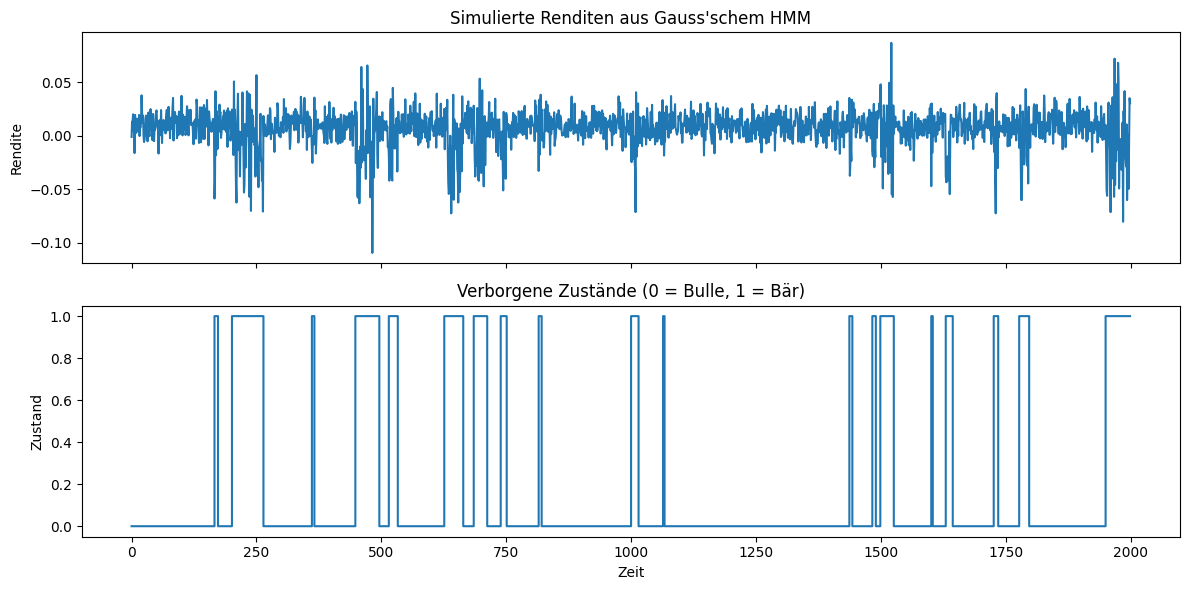

In [2]:

rng = np.random.default_rng(seed=42)

# --- Parameter-Setup ---

# Zustand 0: Bullenmarkt
mu_bull = 0.01    # > 0
sigma_bull = 0.01 # kleinere Volatilität

# Zustand 1: Bärenmarkt
mu_bear = -0.005   # < 0 und |mu_bear| < |mu_bull|
sigma_bear = 0.03  # größere Volatilität

# Übergangsmatrix:
# Reihen: aktueller Zustand, Spalten: nächster Zustand
# [ p(Bulle->Bulle)  p(Bulle->Bär) ]
# [ p(Bär->Bulle)    p(Bär->Bär)   ]
transmat = np.array([
    [1 - 0.01, 0.01],  # Bulle bleibt mit 0.99, wechselt mit 0.01 zu Bär
    [0.05, 1 - 0.05],  # Bär wechselt mit 0.05 zu Bulle, bleibt mit 0.95
])

# Startwahrscheinlichkeiten – z.B. hoher Start im Bullenmarkt
startprob = np.array([0.9, 0.1])

# --- HMM definieren ---

model = GaussianHMM(
    n_components=2,
    covariance_type="diag",
    init_params="",  # ganz wichtig: verhindert, dass hmmlearn Vorgaben überschreibt
    random_state=42,
)

# Mittelwerte (je Zustand ein Vektor)
model.means_ = np.array([[mu_bull], [mu_bear]])           # shape (2, 1)

# Varianzen (sigma^2), diag-Covariance ⇒ shape (2, 1)
model.covars_ = np.array([[sigma_bull**2], [sigma_bear**2]])

model.transmat_ = transmat
model.startprob_ = startprob

# --- Simulation ---

n_samples = 2000  # Länge der simulierten Zeitreihe

observations,hidden_states   = model.sample(n_samples)

# observations: shape (n_samples, 1) → Renditen
returns = observations.ravel()  # zu 1D machen

# --- Optional: kleine Visualisierung ---

time = np.arange(n_samples)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# (1) Renditen
ax[0].plot(time, returns)
ax[0].set_title("Simulierte Renditen aus Gauss'schem HMM")
ax[0].set_ylabel("Rendite")

# (2) Hidden States (0 = Bulle, 1 = Bär)
ax[1].step(time, hidden_states, where="post")
ax[1].set_title("Verborgene Zustände (0 = Bulle, 1 = Bär)")
ax[1].set_xlabel("Zeit")
ax[1].set_ylabel("Zustand")

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

def simulate_hmm_equity_premium(
    n_samples: int = 2000,
    start_date: str = "1950-01-01",
    freq: str = "MS",
    seed: int = 42,
    # --- regime parameters (tune these for “easier/harder” prediction)
    mu_bull: float = 0.012,     # higher mean
    sigma_bull: float = 0.010,  # lower vol
    mu_bear: float = -0.006,    # lower (negative) mean, |mu_bear| < |mu_bull|
    sigma_bear: float = 0.030,  # higher vol
    p_bull_to_bear: float = 0.01,  # lower -> more persistent bull
    p_bear_to_bull: float = 0.05,  # bear lasts shorter on avg
    startprob: tuple = (0.9, 0.1),
    # engineered features for supervised models
    make_features: bool = True,
    vol_windows: tuple = (20, 60),
    mean_windows: tuple = (20, ),
    # target choice: "state_t" (current hidden state) or "state_t_plus_1" (next step)
    target: str = "state_t_plus_1",
):
    """
    Simulate equity-premium-like returns from a 2-state Gaussian HMM and
    return a DataFrame with useful labels/features for classification.

    To make prediction “easier”, increase regime separation (|mu_bull - mu_bear|)
    and persistence (smaller transition probabilities).
    """
    rng = np.random.default_rng(seed)

    # ---- transition matrix ----
    transmat = np.array([
        [1.0 - p_bull_to_bear, p_bull_to_bear],
        [p_bear_to_bull,       1.0 - p_bear_to_bull],
    ], dtype=float)
    startprob = np.asarray(startprob, float)

    # ---- build HMM with fixed params (no re-init) ----
    model = GaussianHMM(
        n_components=2,
        covariance_type="diag",
        init_params="",           # do NOT override our params
        random_state=seed,
    )
    # We define component 0 = bull, 1 = bear (by construction).
    model.means_  = np.array([[mu_bull], [mu_bear]], dtype=float)
    model.covars_ = np.array([[sigma_bull**2], [sigma_bear**2]], dtype=float)
    model.transmat_  = transmat
    model.startprob_ = startprob

    # ---- sample ----
    observations, hidden_states = model.sample(n_samples)  # (T,1), (T,)
    returns = observations.ravel().astype(np.float32)

    # ---- date index ----
    dates = pd.date_range(start=start_date, periods=n_samples, freq=freq)

    # ---- map hidden state -> Bull=1, Bear=0 robustly ----
    # (Just in case, infer by the higher mean instead of trusting index)
    means = model.means_.ravel()
    bull_id = int(np.argmax(means))
    state_true = (hidden_states == bull_id).astype(int)  # 1=bull, 0=bear

    # ---- base frame ----
    df = pd.DataFrame(
        {
            "equity_premium": returns,           # continuous “y”
            "state_true": state_true.astype(int) # latent label at time t
        },
        index=dates,
    )

    # optional engineered features from *past* info only
    if make_features:
        # absolute return often helps separate high-vol bear regimes
        df["abs_ret"] = df["equity_premium"].abs()

        # rolling vols / means (NaN in first windows)
        for w in vol_windows:
            df[f"rv{w}"] = df["equity_premium"].rolling(w, min_periods=w).std()
        for w in mean_windows:
            df[f"ma{w}"] = df["equity_premium"].rolling(w, min_periods=w).mean()


    df["timestamp"] = df.index
    return df, hidden_states, model


In [4]:
# simulate
df, _, _ = simulate_hmm_equity_premium(
    n_samples=2500,
    target="state_t_plus_1",  # forecast next state
    make_features=True,
    vol_windows=(20,60),
    mean_windows=(20,),
    start_date="1850-01-01",
)

# choose features (you can add more)


In [5]:
df

,equity_premium,state_true,abs_ret,rv20,rv60,ma20,timestamp
1850-01-01,0.000881,1,0.000881,NaN,NaN,NaN,1850-01-01
1850-02-01,0.015189,1,0.015189,NaN,NaN,NaN,1850-02-01
1850-03-01,0.014790,1,0.014790,NaN,NaN,NaN,1850-03-01
1850-04-01,0.022105,1,0.022105,NaN,NaN,NaN,1850-04-01
1850-05-01,0.006191,1,0.006191,NaN,NaN,NaN,1850-05-01
...,...,...,...,...,...,...,...
2057-12-01,0.011191,1,0.011191,0.009346,0.008619,0.013422,2057-12-01
2058-01-01,0.017205,1,0.017205,0.009258,0.008631,0.013928,2058-01-01
2058-02-01,0.003821,1,0.003821,0.009415,0.008645,0.013762,2058-02-01
2058-03-01,0.020639,1,0.020639,0.009536,0.008641,0.014146,2058-03-01


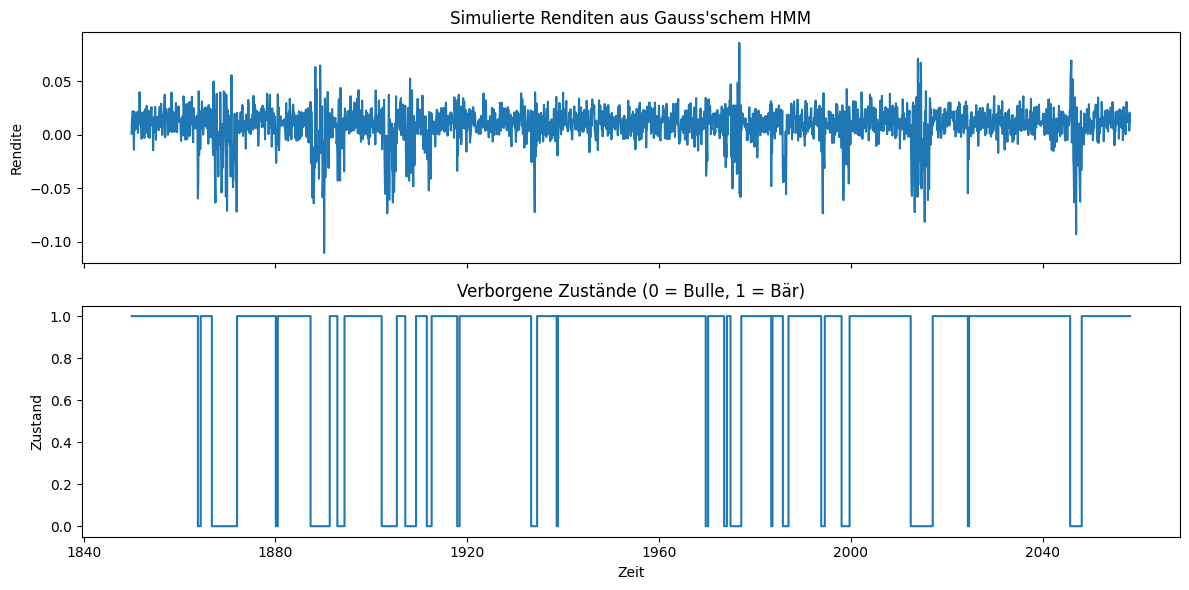

In [6]:


fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# (1) Renditen
ax[0].plot(df["timestamp"], df["equity_premium"].values)
ax[0].set_title("Simulierte Renditen aus Gauss'schem HMM")
ax[0].set_ylabel("Rendite")

# (2) Hidden States (0 = Bulle, 1 = Bär)
ax[1].step(df["timestamp"], df["state_true"].values, where="post")
ax[1].set_title("Verborgene Zustände (0 = Bulle, 1 = Bär)")
ax[1].set_xlabel("Zeit")
ax[1].set_ylabel("Zustand")

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_utils as utils
import source.models_classification as modl


In [10]:
logit_lag_fit_predict = modl.make_logit_multifeature_lag_fit_predict_fn(base_cols = ["equity_premium", "abs_ret", "rv20", "rv60", "ma20"],                # multiple continuous input variables
    target_col = "state_true",
    class_weight={0:5, 1:1})
metrics, y_true, y_pred, dates = utils.expanding_oos_tabular_cls(
    data=df,
    target_col="state_true",
    model_fit_predict_fn=logit_lag_fit_predict,
    start_oos="2007-01-01",
    start_date="1850-01-01"
)
print(metrics)

2007-01-01 00:00:00


KeyboardInterrupt: 

(array([ 87.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 529.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

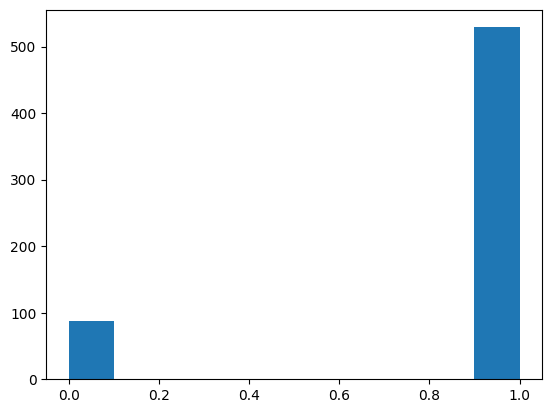

In [ ]:
plt.hist(y_true)


(array([113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 503.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

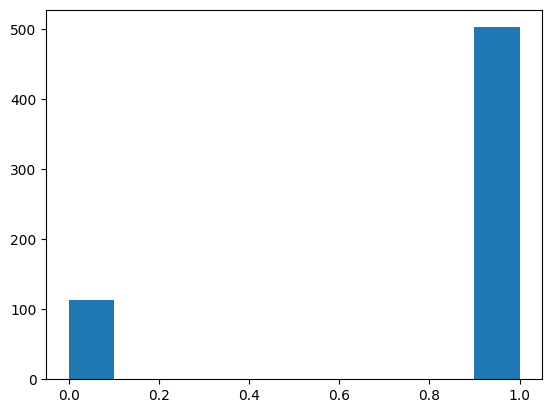

In [ ]:
plt.hist(y_pred)

In [ ]:
base_cols = ["equity_premium", "abs_ret", "rv20", "rv60", "ma20"]


# build lagged-logit predictor (e.g., 3 lags)
fit_predict = make_logit_multifeature_lag_fit_predict_fn(
    base_cols=base_cols,
    target_col="state",
    n_lags=3,
    return_proba=False
)

# OOS expanding classification (your driver)
metrics, y_true, y_pred, dates = expanding_oos_tabular_cls(
    data=df,
    target_col="state",
    start_oos="1960-01-01",
    model_fit_predict_fn=fit_predict,
    baseline_mode="majority",
)

print(metrics)


NameError: name 'make_logit_multifeature_lag_fit_predict_fn' is not defined

In [ ]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_classification as modl
import torch
from chronos import BaseChronosPipeline
import torch
from momentfm import MOMENTPipeline
from sklearn.metrics import roc_curve

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from momentfm import MOMENTPipeline
import matplotlib.pyplot as plt


In [ ]:
df_sim, z = simulate_hmm_equity_premium(
    n_samples=500,
    start_date="1950-01-01",
    freq="MS",
)

In [ ]:
df_sim

In [ ]:
plt.plot(df_sim.index, df_sim["equity_premium"], label="Simulated Equity Premium")

In [ ]:
print("share of true 1s:", y_true_m.mean())
print("share of predicted 1s:", y_hat_m.mean())
print("min/max prob:", y_prob_m.min(), y_prob_m.max())

In [ ]:
plt.hist(y_test_mom)

In [ ]:
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_utils as utils
import source.models_classification as modl